In [1]:
from typing import TypedDict, List
from langchain_ollama import ChatOllama
from langchain_core.prompts import ChatPromptTemplate
from langgraph.graph import StateGraph, END

# --- 1. SETUP MODEL ---
# Using the lightweight Qwen model for speed
llm = ChatOllama(model="qwen2.5:0.5b", temperature=0)

# --- 2. DEFINE STATE ---
class EmailState(TypedDict):
    raw_email: str
    summary: str
    action_items: List[str]
    category: str

# --- 3. DEFINE NODES ---

def summarizer_node(state: EmailState):
    email_text = state["raw_email"]
    
    # We ask for a specific format to make parsing easier
    prompt = ChatPromptTemplate.from_template(
        """You are an executive assistant. Analyze the following email.
        
        1. Summarize it in 1 sentence.
        2. List any action items (start with '-'). If none, say "None".
        3. Categorize it as exactly one of: [Work, Personal, Spam, Newsletter].
        
        Email Content:
        {email}
        
        Output Format:
        Summary: ...
        Actions: ...
        Category: ...
        """
    )
    
    chain = prompt | llm
    response = chain.invoke({"email": email_text})
    content = response.content
    
    # Simple manual parsing of the LLM's output
    # (In production, we would use structured output parsers, but this is great for learning)
    summary = ""
    actions = []
    category = "Uncategorized"
    
    lines = content.split('\n')
    current_section = None
    
    for line in lines:
        line = line.strip()
        if line.startswith("Summary:"):
            summary = line.replace("Summary:", "").strip()
        elif line.startswith("Category:"):
            category = line.replace("Category:", "").strip()
        elif line.startswith("-"):
            actions.append(line)
            
    print(f"✅ Analyzed Email")
    
    return {
        "summary": summary,
        "action_items": actions,
        "category": category
    }

# --- 4. BUILD GRAPH ---

workflow = StateGraph(EmailState)

workflow.add_node("summarizer", summarizer_node)
workflow.set_entry_point("summarizer")
workflow.add_edge("summarizer", END)

app = workflow.compile()

# --- 5. RUN IT ---

# Example 1: A Work Email
email_1 = """
Hi Himanshu,
Could you please review the Q3 financial report attached? 
I need your comments by Friday 5 PM. 
Also, don't forget to update the team calendar for next week.
Thanks,
Sarah
"""

print("--- 📧 PROCESSING EMAIL 1 ---")
result = app.invoke({"raw_email": email_1})

print(f"📂 Category: {result['category']}")
print(f"📝 Summary:  {result['summary']}")
print(f"⚡ Actions:")
for action in result['action_items']:
    print(f"   {action}")

print("\n" + "="*40 + "\n")

# Example 2: A Spam/Promo Email
email_2 = """
CONGRATULATIONS! You have won a free iPhone 15. 
Click the link below to claim your prize now! 
Offer expires in 10 minutes.
"""

print("--- 📧 PROCESSING EMAIL 2 ---")
result = app.invoke({"raw_email": email_2})

print(f"📂 Category: {result['category']}")
print(f"📝 Summary:  {result['summary']}")
print(f"⚡ Actions:")
for action in result['action_items']:
    print(f"   {action}")

--- 📧 PROCESSING EMAIL 1 ---
✅ Analyzed Email
📂 Category: Personal
📝 Summary:  Sarah needs to review the Q3 financial report and update the team calendar.
⚡ Actions:


--- 📧 PROCESSING EMAIL 2 ---
✅ Analyzed Email
📂 Category: Work
📝 Summary:  Congratulations!
⚡ Actions:


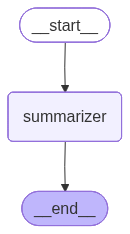

In [3]:
app